# Scenario 7 - Analysis

5.6.2.8	Scenario 7: SS600 km, GSD 50m, 5 sats

Results for this scenario are similar to Scenario 2 with less total data as it has 5 satellites, yet coverage is 1.24 so lower than required twice a day.

### Sizing spatial resolution for orbital estimating data rates of payload

As said, previously the previous block worked as a context for understanding the capabilities as well as upper and lower limits of the constants being used in this problem. Specifically, it was probed that a GSD can be as low as 3.67 [m] however previous iterations of this problem showed a GSD as low as that is far demanding for the link budget. 

In this section, several values of spatial resolution in terms of $R_{GSD}$ and orbit altitudes are defined in order to iterate and define the most suitable scenario to accomplish this mission. 

#### Swath width discussion

Figure XX provides and overview of Planet sensors characteristics that are relevant for the sizing by analogy of our Payload.

![planetscopes sensors.jpg](Figs/planetscopes%20sensores.jpg)

Planet source: https://www.mdpi.com/2072-4292/13/19/3930

In [4]:
R_GSD= 50

H= 6e5

S_w=np.array([19000, 22000, 25000, 30000, 35000, 45000]) ## [m] Estimated from equivalent CubeSat for fire monitoring mission [Asamis et al, 2022]

## Data-rate estimations 

WP04.02 Link sizing and analysis & WP04.03 Payload Data Rate (DR) generation.

The data rate from the payload (i.e generate: $_gen$) from the image is estimated from: 

$$ DR_{gen}= \frac{S_w V_g}{R_{GSD}}b \;\left[ \frac{bit}{s} \right] $$

Where
- $S_w$: Swath width [m] set as 25 [km] from [Azami et al., 2022]
- $b$ : bit rate [bit/s]. Set as 12 [bit/s] from KITSUNE forest monitoring CubeSat mission [Azami et al., 2022]
- $R_{GSD}$: Ground Sample Distance resolution [m], estimated previously based on the relationships by [Valenzuela & Reyes 2019].

To loosen, i.e. make the $R_{GSD} 25 [m]$ for FireSat scenario. Required resolution is 50 m  **(Requirement 34.1.2 Resolution: 50 meter resolution)**

- $V_g$: Ground speed [m/s], estimated as follows [New SMAD - Appendix C]:


$$ V_{g}=R_E \sqrt{\frac{\mu_E}{a^3}} [\frac{m}{s}]$$

Where:
- $\mu_E=3.986004356e14 [m^3/s^2]$ Earth Gravitational Constant  [New SMAD - Spaceflight constants]
- $a=R_E+H$ semi major axis [m]
- $R_{E}=6378136.6 [m]$ Earth equatorial radius [New SMAD - Spaceflight constants]
- $H$ orbital altitude (height) [m]. From the previous cases defined in the INPUT H vector

In [5]:
## SSO a 600 [km],  GSD 25 [m] y S_w 25 [km]-> R_GSD[9], H[1],  S[2]


## Payload Data Rate sizing relations 
mu_E= 3.986004356e14 ## [m^3/s^2] [New SMAD - Spaceflight constants]
R_E=6378136.6 ## [m]$ Earth equatorial radius [m] [New SMAD - Spaceflight constants]

V_g=R_E*np.sqrt(mu_E/(R_E+H)**3)
print('Ground speed velocity:', V_g/1000, ' [km/s]')

#V_g= np.sqrt(mu*(1/(R_E+H))) ## [m/s]

b=12 # [bit]

D_rategenerated= S_w[2]* V_g*b/(R_GSD) #[bit/s]
print('Payload data rate:', D_rategenerated / 1000000, ' [Mbit/s]')

Ground speed velocity: 6.908018639009721  [km/s]
Payload data rate: 41.448111834058324  [Mbit/s]


## PROCESS: DATA GENERATION AND DOWNLOAD

In order to quantify the amount of generated data, the previously calculated data rate ($D_{rategenerated}$) and the median contact time are used such that: 

$$ D_{gen}= D_{rate,generated}*t_{AoI} \; [Mbit] $$

As well to quantify the amount of downloaded data, the download datarate and the median contact time to the ground station are used such that: 
$$ D_{down}= D_{rate,down} *t_{contact-time}  \; [Mbit]$$

Both times $t_{AoI}$ and $t_{contact-time}$ are calculated up next by using the inputs as the results of the simulations on FreeFlyer. The results are extracted both for the cluster in total and for each individual satellite.

### Setup

The following section compiles the previous setup for the program, stating the main relevant variables and libraries to be used.

In [6]:
# Libraries used
from datetime import datetime
import matplotlib.pyplot as plt

# File Paths\n,
# For convenience, the filepaths for each file used will be edited in this cell for user convenience.
FilePathAreaofInterest = 'INPUTS\Scenario7-5sats-SSO-6978km-97.87deg-30d-50mGSD\Contact_Region_SSO_6978_97.87_30_days_R_GSD-50.00.txt'
FilePathSvalbard = 'INPUTS\Scenario7-5sats-SSO-6978km-97.87deg-30d-50mGSD\Contact_Times_Svalbard_SSO_6978_97.87_30_days_R_GSD-50.00.txt'
FilePathCuiaba = 'INPUTS\Scenario7-5sats-SSO-6978km-97.87deg-30d-50mGSD\Contact_Times_Cuiaba_SSO_6978_97.87_30_days_R_GSD-50.00.txt'
FilePathPuntaArenas = 'INPUTS\Scenario7-5sats-SSO-6978km-97.87deg-30d-50mGSD\Contact_Times_PuntaArenas_SSO_6978_97.87_30_days_R_GSD-50.00.txt'

# Simulation timespan
# For aesthetic purposes, please add the simulation time in this variable for title purposes on the graphs
simulation_time = 30

### Time contact Area Of Interest


This algorithm/script takes the OUTPUT contact times from the FreeFlyer Orbital Scenario simulation and obtains per satellite over the area of interest (AoI)

The FREE Flyer OUTPUT with contact times should be name "Contact_Region.txt" and store in the respective "(ISS or SSO)_xxd" where xx is the amount of days of the simulation, these folders should be located inside "INPUTS" folder of this repository.

Note the satellite names should be the same as the ones used in the orbital simulation (i.e. Walker_XX)
Contact time data should be between columns  114 and 125 in the txt file

In [7]:

def parse_date(date_string):    #Defining the date format.
    return datetime.strptime(date_string, '%b %d %Y') #b for abbreviated month (Jan, Feb, etc), d for day (01, 02, etc, 10) and Y for year (2022, 2023, etc)

with open(FilePathAreaofInterest, 'r') as file:   #INPUT/SSO_15d contact report location.
    lines = file.readlines()   #Determines how long should the script be i.e. total lines the FreeFlyer file. 

#Initialize vectors to store data in.

Walker_01_AOI = []    
Walker_02_AOI = []
Walker_03_AOI = []
Walker_04_AOI = []
Walker_05_AOI = []


for line in lines:
    if not line.strip() or 'Entry Epoch' in line:
        continue  
    parts = line.split()
    if len(parts) < 7:  
        continue  ## Reads the "Entry Epoch" column of the output file and checks if the length matches the date format entered. 
 
    satellite = parts[2]  #Reads the satellite name.
    entry_date = parse_date(' '.join(parts[3:6]))   #Reads the date.
    
    duration = float(parts[-1])  #Find the duration of the contact in the last column of the output file. 
    
    #With the read satellite name check if the date already exists, if it does adds up the contact time to the date. 
    #If not, create a new line with new date and respective contact time. 

    #The iterates over each line encountered in "lines = file.readlines()" checking each satellite and date. 
    day = entry_date.date()
    if satellite == 'Walker_1':
        for item in Walker_01_AOI:
            if item[0] == day:
                item[1] += duration
                break
        else:
            Walker_01_AOI.append([day, duration])
    elif satellite == 'Walker_2':
        for item in Walker_02_AOI:
            if item[0] == day:
                item[1] += duration
                break
        else:
            Walker_02_AOI.append([day, duration])
    elif satellite == 'Walker_3':
        for item in Walker_03_AOI:
            if item[0] == day:
                item[1] += duration
                break
        else:
            Walker_03_AOI.append([day, duration])
    elif satellite == 'Walker_4':
        for item in Walker_04_AOI:
            if item[0] == day:
                item[1] += duration
                break
        else:
            Walker_04_AOI.append([day, duration])
    elif satellite == 'Walker_5':
        for item in Walker_05_AOI:
            if item[0] == day:
                item[1] += duration
                break
        else:
            Walker_05_AOI.append([day, duration])


### Time contact per Ground Station


This algorithm/script takes the OUTPUT contact times to Ground Stations from the FreeFlyer Orbital Scenario simulation and obtains connection time for all three Ground Station per satellite per day. The script uses a condition for time named t_min which is the minimal time asked to operate, the conditions is assigned by the user and it should be understood as the minimal time in which a connection between Ground station and satellite can be done. 

The FREE Flyer OUTPUT with contact times should be name "Contact_Times_GroundStation.txt" where GroundStation can be PuntaArenas, Svalbard or Cuiaba and store in the respective "(ISS or SSO)_xxd" where xx is the amount of days of the simulation, these folders should be located inside "INPUTS" folder of this repository.

Note the satellite names should be the same as the ones used in the orbital simulation (i.e. Walker_XX).



#### Svalbard Contact time per day per satellite 

In [8]:
t_min=5 #[min]. Connection time filter

def parse_date(date_string): #Date format definition. 
    return datetime.strptime(date_string, '%b %d %Y') 

with open(FilePathSvalbard, 'r') as file: #Contact_Time_Svalvard location. 
    lines = file.readlines() #Determines how long should the script be i.e. total lines the FreeFlyer file. 


#Initialize vectors to store data in.
Walker_01_Svalbard = []
Walker_02_Svalbard = []
Walker_03_Svalbard = []
Walker_04_Svalbard = []
Walker_05_Svalbard = []


for line in lines:
    if not line.strip() or 'Entry Epoch' in line:
        continue  
    parts = line.split()
    if len(parts) < 7:  
        continue  #Reads the "Entry Epoch" column of the output file and checks if the length matches the date format entered. 


    satellite = parts[2]  #Reads teh satellite name. 
    entry_date = parse_date(' '.join(parts[3:6]))  #Reads the date. 
    
    duration = float(parts[-1]) #Find the duration of the contact in the last column of the output file. 
    
    #With the read satellite name check if the date already exists, if it does adds up the contact time to the date. 
    #If not, create a new line with new date and respective contact time. 

    #Iterates over each line encountered in "lines = file.readlines()" checking each satellite and date. 
    day = entry_date.date()
    if satellite == 'Walker_1':
        if duration >= t_min:
            for item in Walker_01_Svalbard:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_01_Svalbard.append([day, duration])
    elif satellite == 'Walker_2':
        if duration >= t_min:
            for item in Walker_02_Svalbard:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_02_Svalbard.append([day, duration])
    elif satellite == 'Walker_3':
        if duration >= t_min:
            for item in Walker_03_Svalbard:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_03_Svalbard.append([day, duration])
    elif satellite == 'Walker_4':
        if duration >= t_min:
            for item in Walker_04_Svalbard:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_04_Svalbard.append([day, duration])
    elif satellite == 'Walker_5':
        if duration >= t_min:
            for item in Walker_05_Svalbard:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_05_Svalbard.append([day, duration])


#### Punta Arenas contact time per day per satellite 


Both next scripts apply the same process to its respective output file using exactly the same code. 

In [9]:
def parse_date(date_string):
    return datetime.strptime(date_string, '%b %d %Y')

with open(FilePathPuntaArenas, 'r') as file:
    lines = file.readlines()

Walker_01_PuntaArenas = []
Walker_02_PuntaArenas = []
Walker_03_PuntaArenas = []
Walker_04_PuntaArenas = []
Walker_05_PuntaArenas = []


for line in lines:
    if not line.strip() or 'Entry Epoch' in line:
        continue  
    parts = line.split()
    if len(parts) < 7:  
        continue  
    satellite = parts[2]  
    entry_date = parse_date(' '.join(parts[3:6]))  
    
    duration = float(parts[-1])
    
    day = entry_date.date()
    if satellite == 'Walker_1':
        if duration >= t_min:
            for item in Walker_01_PuntaArenas:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_01_PuntaArenas.append([day, duration])
    elif satellite == 'Walker_2':
        if duration >= t_min:
            for item in Walker_02_PuntaArenas:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_02_PuntaArenas.append([day, duration])
    elif satellite == 'Walker_3':
        if duration >= t_min:
            for item in Walker_03_PuntaArenas:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_03_PuntaArenas.append([day, duration])
    elif satellite == 'Walker_4':
        if duration >= t_min:
            for item in Walker_04_PuntaArenas:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_04_PuntaArenas.append([day, duration])
    elif satellite == 'Walker_5':
        if duration >= t_min:
            for item in Walker_05_PuntaArenas:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_05_PuntaArenas.append([day, duration])



#### Cuiaba contact times per day per satellite 

In [10]:
def parse_date(date_string):
    return datetime.strptime(date_string, '%b %d %Y')

with open(FilePathCuiaba, 'r') as file:
    lines = file.readlines()

Walker_01_Cuiaba = []
Walker_02_Cuiaba = []
Walker_03_Cuiaba = []
Walker_04_Cuiaba = []
Walker_05_Cuiaba = []


for line in lines:
    if not line.strip() or 'Entry Epoch' in line:
        continue  
    parts = line.split()
    if len(parts) < 7:  
        continue  
    satellite = parts[2]  
    entry_date = parse_date(' '.join(parts[3:6]))  
    
    duration = float(parts[-1])
    
    day = entry_date.date()
    if satellite == 'Walker_1':
        if duration >= t_min:
            for item in Walker_01_Cuiaba:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_01_Cuiaba.append([day, duration])
    elif satellite == 'Walker_2':
        if duration >= t_min:
            for item in Walker_02_Cuiaba:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_02_Cuiaba.append([day, duration])
    elif satellite == 'Walker_3':
        if duration >= t_min:
            for item in Walker_03_Cuiaba:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_03_Cuiaba.append([day, duration])
    elif satellite == 'Walker_4':
        if duration >= t_min:
            for item in Walker_04_Cuiaba:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_04_Cuiaba.append([day, duration])
    elif satellite == 'Walker_5':
        if duration >= t_min:
            for item in Walker_05_Cuiaba:
                if item[0] == day:
                    item[1] += duration
                    break
            else:
                Walker_05_Cuiaba.append([day, duration])



### OUTPUT: Can we download the data?
- Desired outputs are total generated data per satellite
- Downloadable data per ground station alone (per satellite)
- Combination of 2 or 3 GS per satellite

Calculations of Download data rate $D_{downrate}$

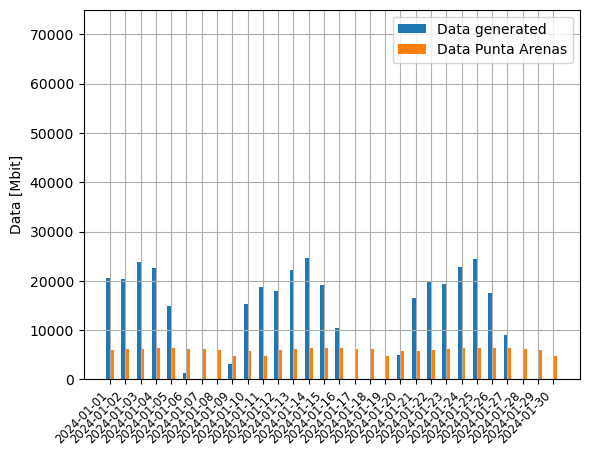

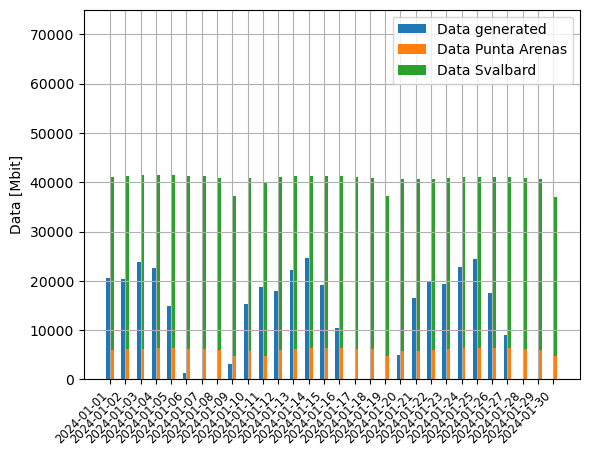

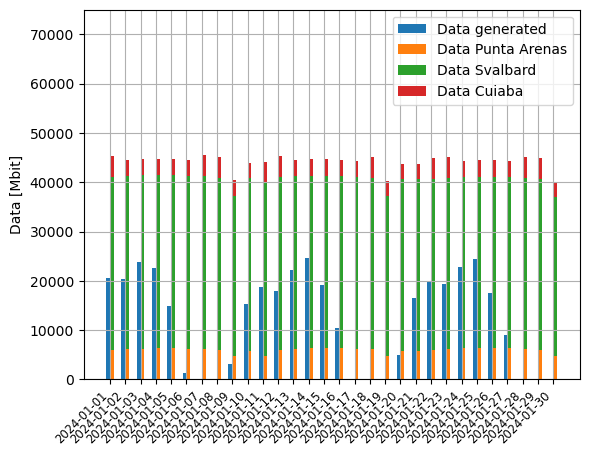

In [11]:

D_ratedown=4.3 #[Mbps] Design parameter based on Band S capabilities (estimated by analogy or Datasheet for S-band transponder )
#https://www.isispace.nl/wp-content/uploads/2023/02/ISIS-TXS2-DSH-0001-TXS2_Datasheet-02_02.pdf
##Note original calculations where done using D_ratedown as 6 Mbps (AL 20240607)



#In case some of the outputs doesn't have results for each day, this function will create and fill out the non existing dates with 0 [min] contact time.
def fill_missing_data(array, all_dates):
    filled_values = []
    for date in all_dates:
        match = np.where(array[:, 0] == date)[0]
        if match.size == 0:
            filled_values.append([date, 0])  
        else:
            filled_values.append(array[match[0]])  
    return np.array(filled_values)



#The following function graphs a bar plot of data generated and downloaded for one satellite and the preferred Ground Station.
# Each required variable and the output its explained below: 
# Vector_AOI: Vector of contact time of the desired satellite over area of interest. 
# Vector_GS1: Vector of contact time between Ground Station 1 and desired satellite.
# Vector_GS2: Vector of contact time between Ground Station 2 and desired satellite.
# Vector_GS3: Vector of contact time between Ground Station 3 and desired satellite.
# D_rategenerated: Value of data rate generation calculated above. IN [BIT/S]
# D_ratedown: Value of data rate download defined above




def graficar(vector_AOI, vector_GS1,vector_GS2,vector_GS3,D_rategenerated,D_ratedown,auxiliar,sat,GS1,GS2,GS3):

    if auxiliar==1:
        vector_AOI=np.array(vector_AOI)
        vector_GS1=np.array(vector_GS1)
        D_gen=[[row[0],row[1]*D_rategenerated*60/1e6] for row in vector_AOI]
        D_down=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_GS1]
       

        values_filled_D_gen_01 = fill_missing_data(np.array(D_gen), vector_GS1[:,0])
        values_filled_D_down_01 = fill_missing_data(np.array(D_down), vector_GS1[:,0])
        
        species = (vector_GS1[:,0])
        penguin_means = {
          'Data generated': values_filled_D_gen_01[:,1] ,
          'Data ' + str(GS1): values_filled_D_down_01[:,1],
          }
        x = np.arange(len(species))  
        width = 0.25  
        multiplier = 0
        fig, ax = plt.subplots()

        for attribute, measurement in penguin_means.items():
            offset = width * multiplier
            rects = ax.bar(x + offset, measurement, width, label=attribute)
            multiplier += 1

        ax.set_ylabel('Data [Mbit]')
        ax.set_xticks(x + width / 2, species)  
        ax.set_xticklabels(species, fontsize='small', rotation=45, ha='right')
        ax.legend(loc='best')
        ax.grid(True)
        ax.set_ylim(0, 75000)
        plt.show()  


    if auxiliar==2:
        vector_AOI=np.array(vector_AOI)
        vector_GS1=np.array(vector_GS1)
        vector_GS2=np.array(vector_GS2)

        D_gen=[[row[0],row[1]*D_rategenerated*60/1e6] for row in vector_AOI]
        D_down1=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_GS1]
        D_down2=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_GS2]
       

        values_filled_D_gen_01 = fill_missing_data(np.array(D_gen), vector_GS1[:,0])
        values_filled_D_down_01 = fill_missing_data(np.array(D_down1), vector_GS1[:,0])
        values_filled_D_down_02= fill_missing_data(np.array(D_down2), vector_GS2[:,0])

        bottom = np.zeros(simulation_time)

        species = (vector_GS1[:,0])
        penguin_means = {
          'Data generated': tuple(values_filled_D_gen_01[:,1]),
          'Data ' + str(GS1): tuple(values_filled_D_down_01[:,1]),
          'Data ' + str(GS2): tuple(values_filled_D_down_02[:,1]),
          }
        x = np.arange(len(species))
        width = 0.25  
        multiplier = 0
        fig, ax = plt.subplots()

        for attribute, measurement in penguin_means.items():
            offset = width * multiplier
            if attribute == 'Data generated':
                rects = ax.bar(x + offset, measurement, width, label=attribute)
                multiplier += 1
            else:
                rects = ax.bar(x + offset, measurement, width, label=attribute, bottom=bottom)
                bottom += measurement

        ax.set_ylabel('Data [Mbit]')
        ax.set_xticks(x + width / 2, species) 
        ax.set_xticklabels(species, fontsize='small', rotation=45, ha='right')
        ax.legend(loc='best')
        ax.grid(True)
        ax.set_ylim(0, 75000)
        plt.show() 

    if auxiliar==3:
        vector_AOI=np.array(vector_AOI)
        vector_GS1=np.array(vector_GS1)
        vector_GS2=np.array(vector_GS2)
        vector_GS3=np.array(vector_GS3)

        D_gen=[[row[0],row[1]*D_rategenerated*60/1e6] for row in vector_AOI]
        D_down1=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_GS1]
        D_down2=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_GS2]
        D_down3=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_GS3]
       
        values_filled_D_gen_01 = fill_missing_data(np.array(D_gen), vector_GS1[:,0])

        values_filled_D_down_01= fill_missing_data(np.array(D_down1), vector_GS1[:,0])
        values_filled_D_down_02= fill_missing_data(np.array(D_down2), vector_GS2[:,0])
        values_filled_D_down_03= fill_missing_data(np.array(D_down3), vector_GS3[:,0])

        species = (vector_GS1[:,0])
        penguin_means = {
          'Data generated': tuple(values_filled_D_gen_01[:,1]),
          'Data ' + str(GS1): tuple(values_filled_D_down_01[:,1]),
          'Data ' + str(GS2): tuple(values_filled_D_down_02[:,1]),
          'Data ' + str(GS3): tuple(values_filled_D_down_03[:,1]),
          }
        x = np.arange(len(species))
        width = 0.25  
        multiplier = 0
        bottom = np.zeros(simulation_time)
        fig, ax = plt.subplots()

        for attribute, measurement in penguin_means.items():
            offset = width * multiplier
            if attribute == 'Data generated':
                rects = ax.bar(x + offset, measurement, width, label=attribute)
                multiplier += 1
            else:
                rects = ax.bar(x + offset, measurement, width, label=attribute, bottom=bottom)
                bottom += measurement

        ax.set_ylabel('Data [Mbit]')
        ax.set_xticks(x + width / 2, species)  
        ax.set_xticklabels(species, fontsize='small', rotation=45, ha='right')  
        ax.legend(loc='best')
        ax.grid(True)
        ax.set_ylim(0, 75000)
        plt.show()  
    
    return 

graf1=graficar(Walker_01_AOI,Walker_01_PuntaArenas,Walker_01_Svalbard,Walker_01_Cuiaba,D_rategenerated,D_ratedown,1,'Walker 01','Punta Arenas','Svalbard','Cuiaba')
graf2=graficar(Walker_01_AOI,Walker_01_PuntaArenas,Walker_01_Svalbard,Walker_01_Cuiaba,D_rategenerated,D_ratedown,2,'Walker 01','Punta Arenas','Svalbard','Cuiaba')
graf3=graficar(Walker_01_AOI,Walker_01_PuntaArenas,Walker_01_Svalbard,Walker_01_Cuiaba,D_rategenerated,D_ratedown,3,'Walker 01','Punta Arenas','Svalbard','Cuiaba')


### Contact times to Ground stations per satellite


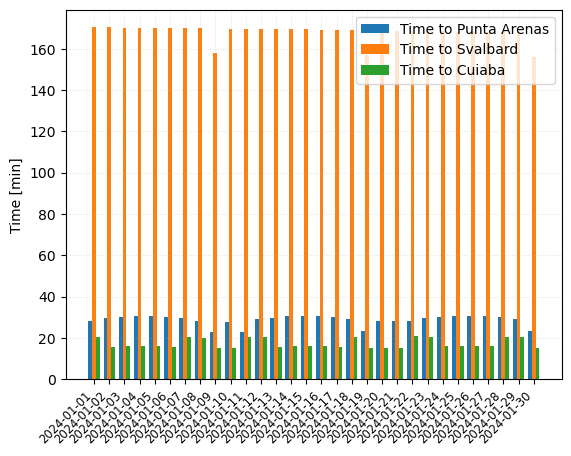

In [12]:
def tiempos_GS(vector_GS1,vector_GS2,vector_GS3,sat,GS1,GS2,GS3): 

  vector_GS1=np.array(vector_GS1)
  vector_GS2=np.array(vector_GS2)
  vector_GS3=np.array(vector_GS3)
    
  ejex = (vector_GS1[:,0])
  barras = {
  'Time to '+str(GS1)+'': vector_GS1[:,1],
  'Time to '+str(GS2)+'': vector_GS2[:,1],
  'Time to '+str(GS3)+'': vector_GS3[:,1],
  }

  x = np.arange(len(ejex))
  width = 0.25  
  multiplier = 0
  fig, ax = plt.subplots()

  for attribute, measurement in barras.items():
   offset = width * multiplier
   rects = ax.bar(x + offset, measurement, width, label=attribute) 
   multiplier += 1


  ax.set_ylabel('Time [min]')
  ax.set_xticks(x + width * 1) 
  ax.set_xticklabels(ejex, fontsize='small', rotation=45, ha='right')
  ax.legend(loc='best')
  ax.grid(True, linewidth=0.5, linestyle=':', alpha=0.5)  # Adjust grid thickness, style, and transparency
  plt.show()
       
  return 

tiempos_GS(Walker_01_PuntaArenas, Walker_01_Svalbard, Walker_01_Cuiaba,'Walker 01','Punta Arenas','Svalbard','Cuiaba')


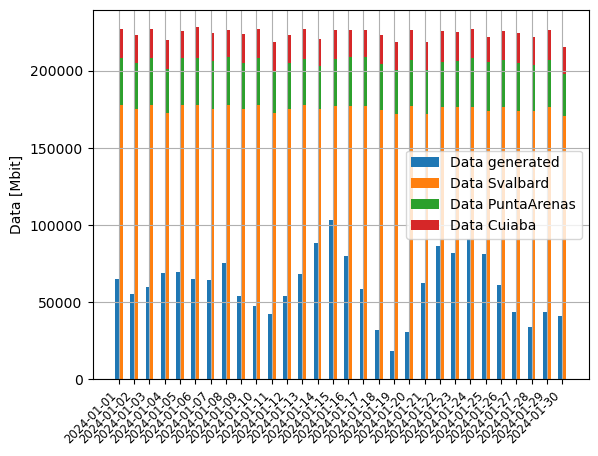

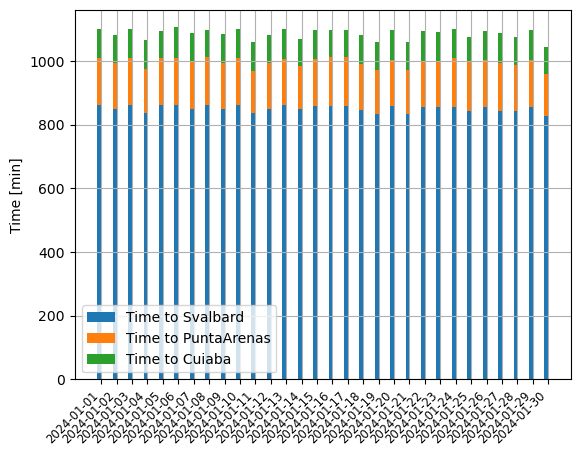

In [13]:
def graficarsuma(Walker_01_AOI,Walker_02_AOI,Walker_03_AOI,Walker_04_AOI,Walker_05_AOI,
                  Walker_01_Svalbard,Walker_02_Svalbard,Walker_03_Svalbard,Walker_04_Svalbard,Walker_05_Svalbard,
                  Walker_01_PuntaArenas,Walker_02_PuntaArenas,Walker_03_PuntaArenas,Walker_04_PuntaArenas,Walker_05_PuntaArenas,
                  Walker_01_Cuiaba,Walker_02_Cuiaba,Walker_03_Cuiaba,Walker_04_Cuiaba,Walker_05_Cuiaba,
                  D_rategenerated,D_ratedown,GS1,GS2,GS3):

    vector_Walker_1_AOI=np.array(Walker_01_AOI)
    vector_Walker_2_AOI=np.array(Walker_02_AOI)
    vector_Walker_3_AOI=np.array(Walker_03_AOI)
    vector_Walker_4_AOI=np.array(Walker_04_AOI)
    vector_Walker_5_AOI=np.array(Walker_05_AOI)

    vector_Walker_1_GS1=np.array(Walker_01_Svalbard)
    vector_Walker_2_GS1=np.array(Walker_02_Svalbard)
    vector_Walker_3_GS1=np.array(Walker_03_Svalbard)
    vector_Walker_4_GS1=np.array(Walker_04_Svalbard)
    vector_Walker_5_GS1=np.array(Walker_05_Svalbard)

    vector_Walker_1_GS2=np.array(Walker_01_PuntaArenas)
    vector_Walker_2_GS2=np.array(Walker_02_PuntaArenas)
    vector_Walker_3_GS2=np.array(Walker_03_PuntaArenas)
    vector_Walker_4_GS2=np.array(Walker_04_PuntaArenas)
    vector_Walker_5_GS2=np.array(Walker_05_PuntaArenas)

    vector_Walker_1_GS3=np.array(Walker_01_Cuiaba)
    vector_Walker_2_GS3=np.array(Walker_02_Cuiaba)
    vector_Walker_3_GS3=np.array(Walker_03_Cuiaba)
    vector_Walker_4_GS3=np.array(Walker_04_Cuiaba)
    vector_Walker_5_GS3=np.array(Walker_05_Cuiaba)



    D_gen_1=[[row[0],row[1]*D_rategenerated*60/1e6] for row in vector_Walker_1_AOI]
    D_gen_2=[[row[0],row[1]*D_rategenerated*60/1e6] for row in vector_Walker_2_AOI]
    D_gen_3=[[row[0],row[1]*D_rategenerated*60/1e6] for row in vector_Walker_3_AOI]
    D_gen_4=[[row[0],row[1]*D_rategenerated*60/1e6] for row in vector_Walker_4_AOI]
    D_gen_5=[[row[0],row[1]*D_rategenerated*60/1e6] for row in vector_Walker_5_AOI]


    D_down_Svalbard_1=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_1_GS1]
    D_down_Svalbard_2=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_2_GS1]
    D_down_Svalbard_3=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_3_GS1]
    D_down_Svalbard_4=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_4_GS1]
    D_down_Svalbard_5=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_5_GS1]

    D_down_PuntaArenas_1=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_1_GS2]
    D_down_PuntaArenas_2=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_2_GS2]
    D_down_PuntaArenas_3=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_3_GS2]
    D_down_PuntaArenas_4=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_4_GS2]
    D_down_PuntaArenas_5=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_5_GS2]

    D_down_Cuiaba_1=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_1_GS3]
    D_down_Cuiaba_2=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_2_GS3]
    D_down_Cuiaba_3=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_3_GS3]
    D_down_Cuiaba_4=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_4_GS3]
    D_down_Cuiaba_5=[[row[0],row[1]*D_ratedown*0.8*60] for row in vector_Walker_5_GS3]

    values_filled_D_gen_01 = fill_missing_data(np.array(D_gen_1), vector_Walker_1_GS1[:,0])
    values_filled_D_gen_02 = fill_missing_data(np.array(D_gen_2), vector_Walker_2_GS1[:,0])
    values_filled_D_gen_03 = fill_missing_data(np.array(D_gen_3), vector_Walker_3_GS1[:,0])
    values_filled_D_gen_04 = fill_missing_data(np.array(D_gen_4), vector_Walker_4_GS1[:,0])
    values_filled_D_gen_05 = fill_missing_data(np.array(D_gen_5), vector_Walker_5_GS1[:,0])
   
    values_filled_D_down_Svalbard_01= fill_missing_data(np.array(D_down_Svalbard_1), vector_Walker_1_GS1[:,0])
    values_filled_D_down_Svalbard_02= fill_missing_data(np.array(D_down_Svalbard_2), vector_Walker_2_GS1[:,0])
    values_filled_D_down_Svalbard_03= fill_missing_data(np.array(D_down_Svalbard_3), vector_Walker_3_GS1[:,0])
    values_filled_D_down_Svalbard_04= fill_missing_data(np.array(D_down_Svalbard_4), vector_Walker_4_GS1[:,0])
    values_filled_D_down_Svalbard_05= fill_missing_data(np.array(D_down_Svalbard_5), vector_Walker_5_GS1[:,0])

    values_filled_D_down_PuntaArenas_01= fill_missing_data(np.array(D_down_PuntaArenas_1), vector_Walker_1_GS2[:,0])
    values_filled_D_down_PuntaArenas_02= fill_missing_data(np.array(D_down_PuntaArenas_2), vector_Walker_2_GS2[:,0])
    values_filled_D_down_PuntaArenas_03= fill_missing_data(np.array(D_down_PuntaArenas_3), vector_Walker_3_GS2[:,0])
    values_filled_D_down_PuntaArenas_04= fill_missing_data(np.array(D_down_PuntaArenas_4), vector_Walker_4_GS2[:,0])
    values_filled_D_down_PuntaArenas_05= fill_missing_data(np.array(D_down_PuntaArenas_5), vector_Walker_5_GS2[:,0])

    values_filled_D_down_Cuiaba_01= fill_missing_data(np.array(D_down_Cuiaba_1), vector_Walker_1_GS3[:,0])
    values_filled_D_down_Cuiaba_02= fill_missing_data(np.array(D_down_Cuiaba_2), vector_Walker_2_GS3[:,0])
    values_filled_D_down_Cuiaba_03= fill_missing_data(np.array(D_down_Cuiaba_3), vector_Walker_3_GS3[:,0])
    values_filled_D_down_Cuiaba_04= fill_missing_data(np.array(D_down_Cuiaba_4), vector_Walker_4_GS3[:,0])
    values_filled_D_down_Cuiaba_05= fill_missing_data(np.array(D_down_Cuiaba_5), vector_Walker_5_GS3[:,0])

    values_filled_Svalbard_01= fill_missing_data(vector_Walker_1_GS1, vector_Walker_1_GS1[:,0])
    values_filled_Svalbard_02= fill_missing_data(vector_Walker_2_GS1, vector_Walker_2_GS1[:,0])
    values_filled_Svalbard_03= fill_missing_data(vector_Walker_3_GS1, vector_Walker_3_GS1[:,0])
    values_filled_Svalbard_04= fill_missing_data(vector_Walker_4_GS1, vector_Walker_4_GS1[:,0])
    values_filled_Svalbard_05= fill_missing_data(vector_Walker_5_GS1, vector_Walker_5_GS1[:,0])

    values_filled_PuntaArenas_01= fill_missing_data(vector_Walker_1_GS2, vector_Walker_1_GS2[:,0])
    values_filled_PuntaArenas_02= fill_missing_data(vector_Walker_2_GS2, vector_Walker_2_GS2[:,0])
    values_filled_PuntaArenas_03= fill_missing_data(vector_Walker_3_GS2, vector_Walker_3_GS2[:,0])
    values_filled_PuntaArenas_04= fill_missing_data(vector_Walker_4_GS2, vector_Walker_4_GS2[:,0])
    values_filled_PuntaArenas_05= fill_missing_data(vector_Walker_5_GS2, vector_Walker_5_GS2[:,0])

    values_filled_Cuiaba_01= fill_missing_data(vector_Walker_1_GS3, vector_Walker_1_GS3[:,0])
    values_filled_Cuiaba_02= fill_missing_data(vector_Walker_2_GS3, vector_Walker_2_GS3[:,0])
    values_filled_Cuiaba_03= fill_missing_data(vector_Walker_3_GS3, vector_Walker_3_GS3[:,0])
    values_filled_Cuiaba_04= fill_missing_data(vector_Walker_4_GS3, vector_Walker_4_GS3[:,0])
    values_filled_Cuiaba_05= fill_missing_data(vector_Walker_5_GS3, vector_Walker_5_GS3[:,0])

    sum_AoI = values_filled_D_gen_01[:,1] + values_filled_D_gen_02[:,1] + values_filled_D_gen_03[:,1] + values_filled_D_gen_04[:,1] + values_filled_D_gen_05[:,1]
    Final_AoI=np.column_stack((values_filled_D_gen_01[:, 0], sum_AoI))

    sum_Svalbard = values_filled_D_down_Svalbard_01[:,1] + values_filled_D_down_Svalbard_02[:,1] + values_filled_D_down_Svalbard_03[:,1] + values_filled_D_down_Svalbard_04[:,1] + values_filled_D_down_Svalbard_05[:,1]
    Final_Svalbard=np.column_stack((values_filled_D_down_Svalbard_01[:, 0], sum_Svalbard))

    Sum_times_Svalbard = values_filled_Svalbard_01[:,1] + values_filled_Svalbard_02[:,1] + values_filled_Svalbard_03[:,1] + values_filled_Svalbard_04[:,1] + values_filled_Svalbard_05[:,1] 
    Final_Times_Svalbard=np.column_stack((values_filled_Svalbard_01[:, 0], Sum_times_Svalbard))
    
    sum_PuntaArenas = values_filled_D_down_PuntaArenas_01[:,1] + values_filled_D_down_PuntaArenas_02[:,1] + values_filled_D_down_PuntaArenas_03[:,1] + values_filled_D_down_PuntaArenas_04[:,1] + values_filled_D_down_PuntaArenas_05[:,1]
    Final_PuntaArenas=np.column_stack((values_filled_D_down_PuntaArenas_01[:, 0], sum_PuntaArenas))

    Sum_times_PuntaArenas = values_filled_PuntaArenas_01[:,1] + values_filled_PuntaArenas_02[:,1] + values_filled_PuntaArenas_03[:,1] + values_filled_PuntaArenas_04[:,1] + values_filled_PuntaArenas_05[:,1]
    Final_Times_PuntaArenas=np.column_stack((values_filled_PuntaArenas_01[:, 0], Sum_times_PuntaArenas))

    sum_Cuiaba = values_filled_D_down_Cuiaba_01[:,1] + values_filled_D_down_Cuiaba_02[:,1] + values_filled_D_down_Cuiaba_03[:,1] + values_filled_D_down_Cuiaba_04[:,1] + values_filled_D_down_Cuiaba_05[:,1]
    Final_Cuiaba=np.column_stack((values_filled_D_down_Cuiaba_01[:, 0], sum_Cuiaba))

    Sum_times_Cuiaba = values_filled_Cuiaba_01[:,1] + values_filled_Cuiaba_02[:,1] + values_filled_Cuiaba_03[:,1] + values_filled_Cuiaba_04[:,1] + values_filled_Cuiaba_05[:,1]
    Final_Times_Cuiaba=np.column_stack((values_filled_D_down_Cuiaba_01[:, 0], Sum_times_Cuiaba))

    times = {
        'Time to '+str(GS1)+'': tuple(Final_Times_Svalbard[:,1]),
        'Time to '+str(GS2)+'': tuple(Final_Times_PuntaArenas[:,1]),
        'Time to '+str(GS3)+'': tuple(Final_Times_Cuiaba[:,1]),
    }

    species = (vector_Walker_1_GS1[:,0])
    penguin_means = {
        'Data generated': tuple(Final_AoI[:,1]),
        'Data ' + str(GS1): tuple(Final_Svalbard[:,1]),
        'Data ' + str(GS2): tuple(Final_PuntaArenas[:,1]),
        'Data ' + str(GS3): tuple(Final_Cuiaba[:,1]),
    }
    


    x = np.arange(len(species))
    width = 0.25  
    multiplier = 0
    bottom = np.zeros(simulation_time)
    fig, ax = plt.subplots()

    for attribute, measurement in penguin_means.items():
        offset = width * multiplier
        if attribute == 'Data generated':
            rects = ax.bar(x + offset, measurement, width, label=attribute)
            multiplier += 1
        else:
            rects = ax.bar(x + offset, measurement, width, label=attribute, bottom=bottom)
            bottom += measurement

    ax.set_ylabel('Data [Mbit]')
    ax.set_xticks(x + width / 2, species)  
    ax.set_xticklabels(species, fontsize='small', rotation=45, ha='right')  
    ax.legend(loc='best')
    ax.grid(True)
    plt.show()

    y = np.arange(len(species))
    width = 0.25  
    multiplier = 0
    bottom = np.zeros(simulation_time)
    fig1, ax1 = plt.subplots()

    for attribute, measurement in times.items():
        offset = width * multiplier
        if attribute == 'Data generated':
            rect = ax1.bar(y + offset, measurement, width, label=attribute)
            multiplier += 1
        else:
            rect = ax1.bar(y + offset, measurement, width, label=attribute, bottom=bottom)
            bottom += measurement

    ax1.set_ylabel('Time [min]')
    ax1.set_xticks(y + width / 2, species)  
    ax1.set_xticklabels(species, fontsize='small', rotation=45, ha='right')  
    ax1.legend(loc='best')
    ax1.grid(True)
    plt.show()

graficarsuma(Walker_01_AOI,Walker_02_AOI,Walker_03_AOI,Walker_04_AOI,Walker_05_AOI,
                  Walker_01_Svalbard,Walker_02_Svalbard,Walker_03_Svalbard,Walker_04_Svalbard,Walker_05_Svalbard,
                  Walker_01_PuntaArenas,Walker_02_PuntaArenas,Walker_03_PuntaArenas,Walker_04_PuntaArenas,Walker_05_PuntaArenas,
                  Walker_01_Cuiaba,Walker_02_Cuiaba,Walker_03_Cuiaba,Walker_04_Cuiaba,Walker_05_Cuiaba,
                  D_rategenerated,D_ratedown,'Svalbard','PuntaArenas','Cuiaba')

### References

-Valenzuela, A. Q., & Reyes, J. C. G. (2019). Basic Spatial Resolution Metrics for Satellite Imagers. IEEE Sensors Journal, 19(13), 4914–4922. https://doi.org/10.1109/JSEN.2019.2902512

- Azami, M. H. bin, Orger, N. C., Schulz, V. H., Oshiro, T., Alarcon, J. R. C., Maskey, A., Nakayama, K., Fukuda, Y., Kojima, K., Yamauchi, T., Masui, H., & Cho, M. (2022). Design and environmental testing of imaging payload for a 6 U CubeSat at low Earth orbit: KITSUNE mission. Frontiers in Space Technologies, 3(November), 1–16. https://doi.org/10.3389/frspt.2022.1000219